### Informative score and similarity analysis

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
def plot_correaltions_all(dname1,name1,abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    sns.set_palette('GnBu',6)
    dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
    dnames.sort(reverse=True)
    activities=pd.Series()
    similiarities=pd.Series()
    sizes=pd.Series()
    dset_names=[]
    for dname in dnames:
        activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                         sep=',',header=0,index_col=0).abs().max(1)
        if dname1<dname:
            fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
        else:
            fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
        similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
        size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                         header=0,index_col=0)
        size=size['Set'].value_counts()
        if dname1<dname:
            similarity=similarity.max(0)
        else:
            similarity=similarity.max(1)
        sets=list(set(activity.index)&set(similarity.index)) 
        activities=pd.concat([activities,activity[sets]])   
        similiarities=pd.concat([similiarities,similarity[sets]])
        sizes=pd.concat([sizes,size[sets]])
        if 'dorothea' not in dname:
            dset_names+=[dname]*len(sets)
        elif dname == 'BEST_dorothea_AB':
            dset_names += ['High confidence\nDoRothEA']*len(sets)
        else:
            dset_names += ['Low confidence\nDoRothEA']*len(sets)
    plt.figure(figsize=(4,3),dpi=300)
    sns.scatterplot(similiarities,activities,hue=dset_names, alpha=0.7)
    if sim_type=='jaccard':
        sim_label='Jaccard index'
    else:
        sim_label='Overlap coefficient'
    plt.xlabel('Similarity to '+name1+'\n('+sim_label+')',size=13)
    plt.ylabel('Informative score',size=13)
    plt.legend(fontsize=7)
    plt.tight_layout()
    print(scor(activities,similiarities))

SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)


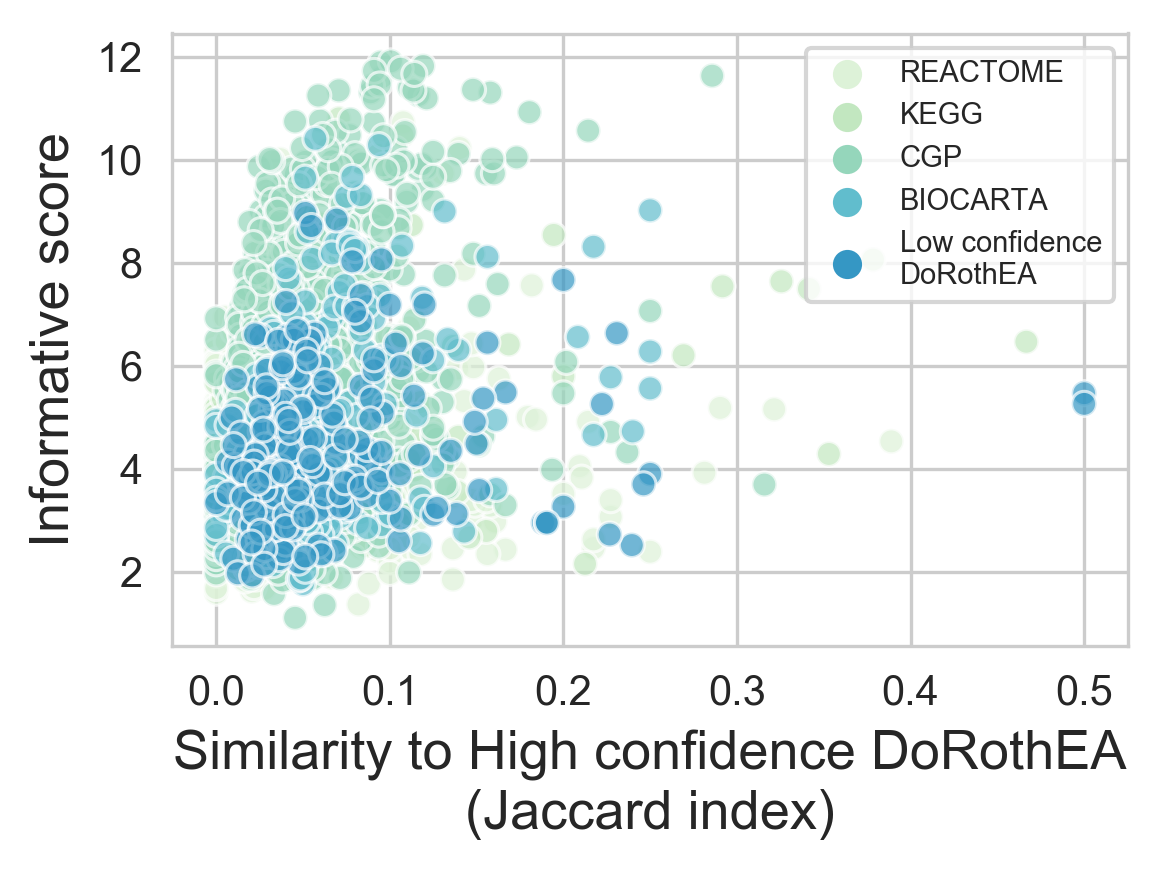

In [6]:
plot_correaltions_all('BEST_dorothea_AB','High confidence DoRothEA','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4A.pdf')

SpearmanrResult(correlation=0.030150997717194566, pvalue=0.03481435101401067)


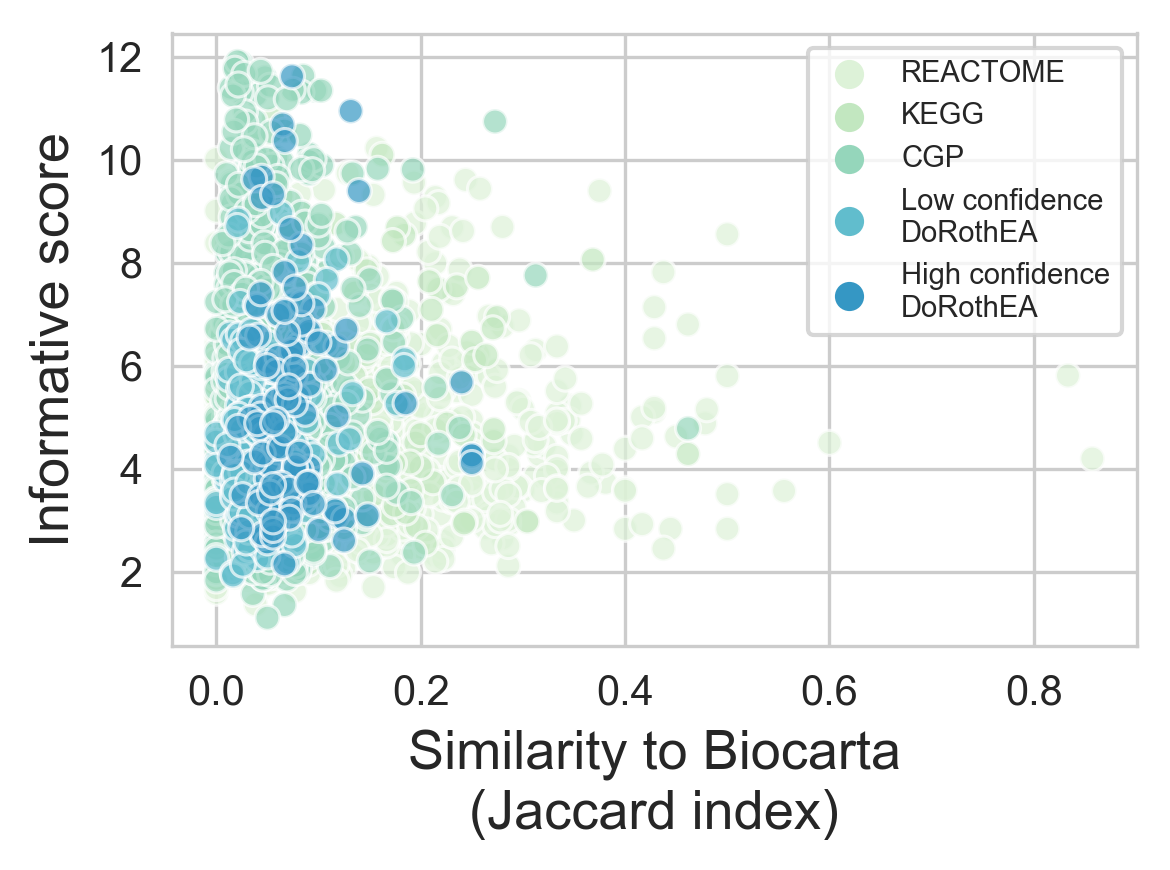

In [7]:
plot_correaltions_all('BIOCARTA','Biocarta','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4B.pdf')

In [121]:
def get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard',
                                 visualise = False):
    dsets={'BEST_dorothea_AB':'High confidence\nDoRothEA',
           'BEST_dorothea_CD':'Low confidence\nDoRothEA',
           'KEGG':'KEGG',
           'BIOCARTA':'BIOCARTA',
           'REACTOME':'REACTOME',
           'CGP':'CGP'}
    dset_names1 = []
    dset_names2 = []
    activities = []
    similiarities = []
    sizes = []
    for dname1 in dsets:
        dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
        dnames.sort(reverse=True)
        for dname in dnames:
            activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                             sep=',',header=0,index_col=0).abs().max(1)
            if dname1<dname:
                fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
            else:
                fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
            similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
            size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                             header=0,index_col=0)
            size=size['Set'].value_counts()
            if dname1<dname:
                similarity=similarity.max(0)
            else:
                similarity=similarity.max(1)
            sets=list(set(activity.index)&set(similarity.index)) 
            activities += list(activity[sets])
            similiarities += list(similarity[sets])
            sizes += list(size[sets])
            dset_names1 += [dname1] * len(sets)
            dset_names2 += [dname] * len(sets)
    results = pd.DataFrame(index = range(len(activities)))
    results['Activity'] = activities; results['Similarity'] = similiarities
    results['Size'] = sizes; results['Dataset1'] = dset_names1; results['Dataset2'] = dset_names2
    stat_results = pd.DataFrame(columns = ['Database', 'r_spearman', 'p_spearman', 'r_part', 'p_part'] )
    i = 0
    for dset in results['Dataset1'].unique():
            fil = results['Dataset1'] == dset
            model1 = smf.ols('Activity ~ Size', results[fil]).fit()
            model2 = smf.ols('Similarity ~ Size', results[fil]).fit()
            stat_results.loc[i] = [dset] + list(scor(results['Activity'][fil], results['Similarity'][fil])) +\
                list(pcor(model1.resid, model2.resid))
            i += 1
    stat_results.index = stat_results['Database']
    stat_results = stat_results.loc[['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']]
    stat_results['Database'] = stat_results['Database'].map(dsets)
    stat_results['Random'] = rnd_fil
    stat_results['Benchmark'] = bname
    stat_results['Abs'] = abs_type
    if visualise:
        sns.set_palette('GnBu',2)
        plt.figure(figsize=(4,4),dpi=300)
        plt.stem(np.arange(0.5,6.5,1), stat_results['r_part'])
        plt.xticks(np.arange(0.5,6.5,1), stat_results['Database'], rotation=45)
        plt.ylim(-0.1,0.3)
        plt.xlabel('Similarity to gene set database', size=13)
        plt.ylabel('Partial correlation between\nsimilarity and infromative score', size=13)
        plt.tight_layout()
    return stat_results

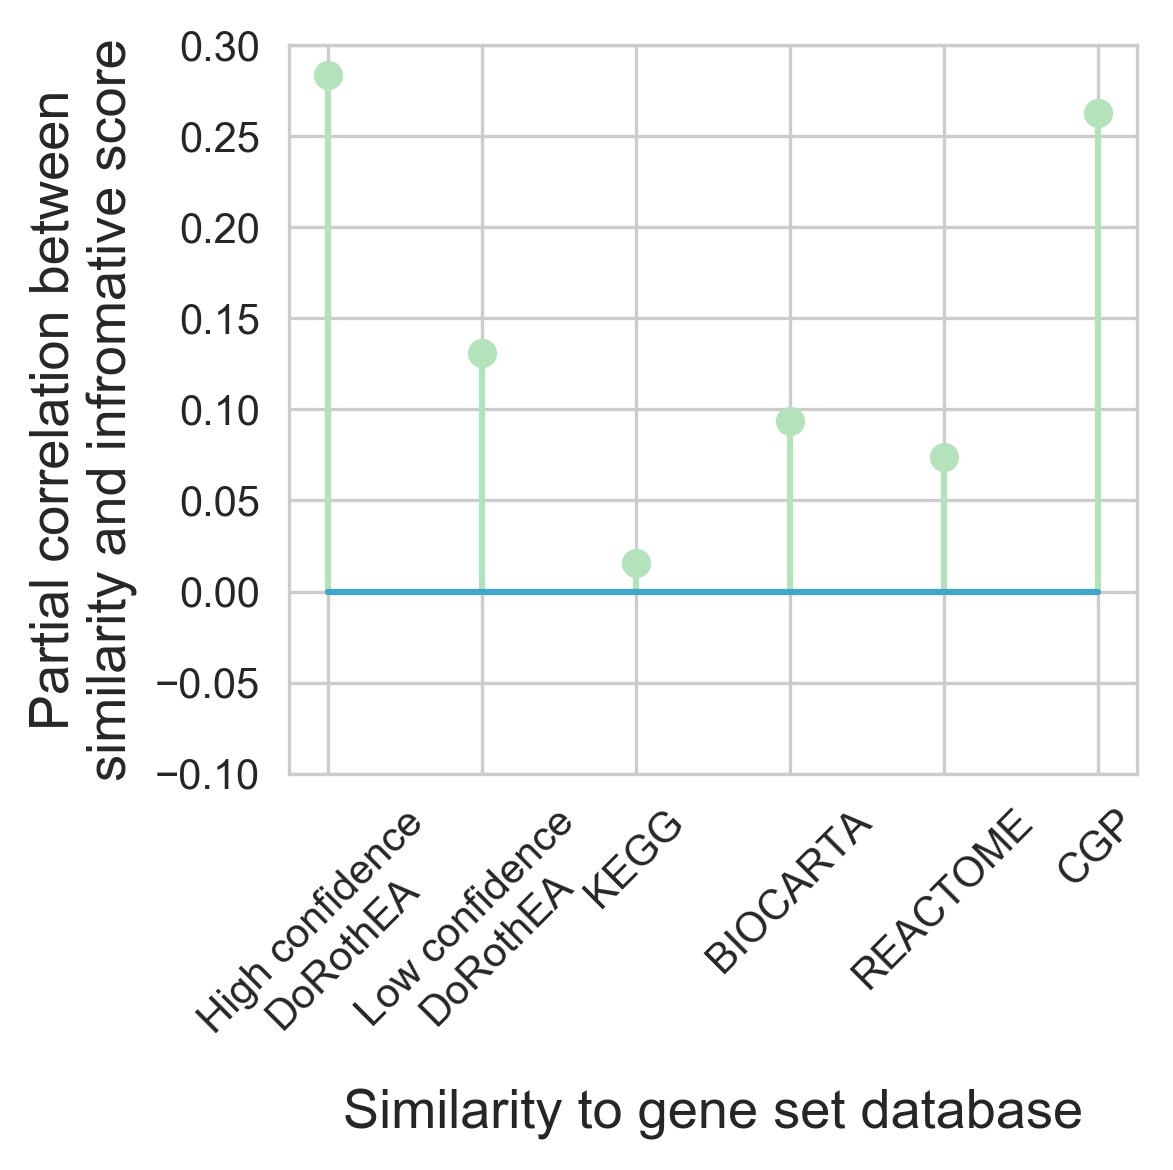

In [126]:
results1 = get_correlations_all_datasets(sim_type='jaccard', rnd_fil='_filtered', bname='progeny', visualise=True)
plt.savefig('../figures/raw/Fig4C.pdf')

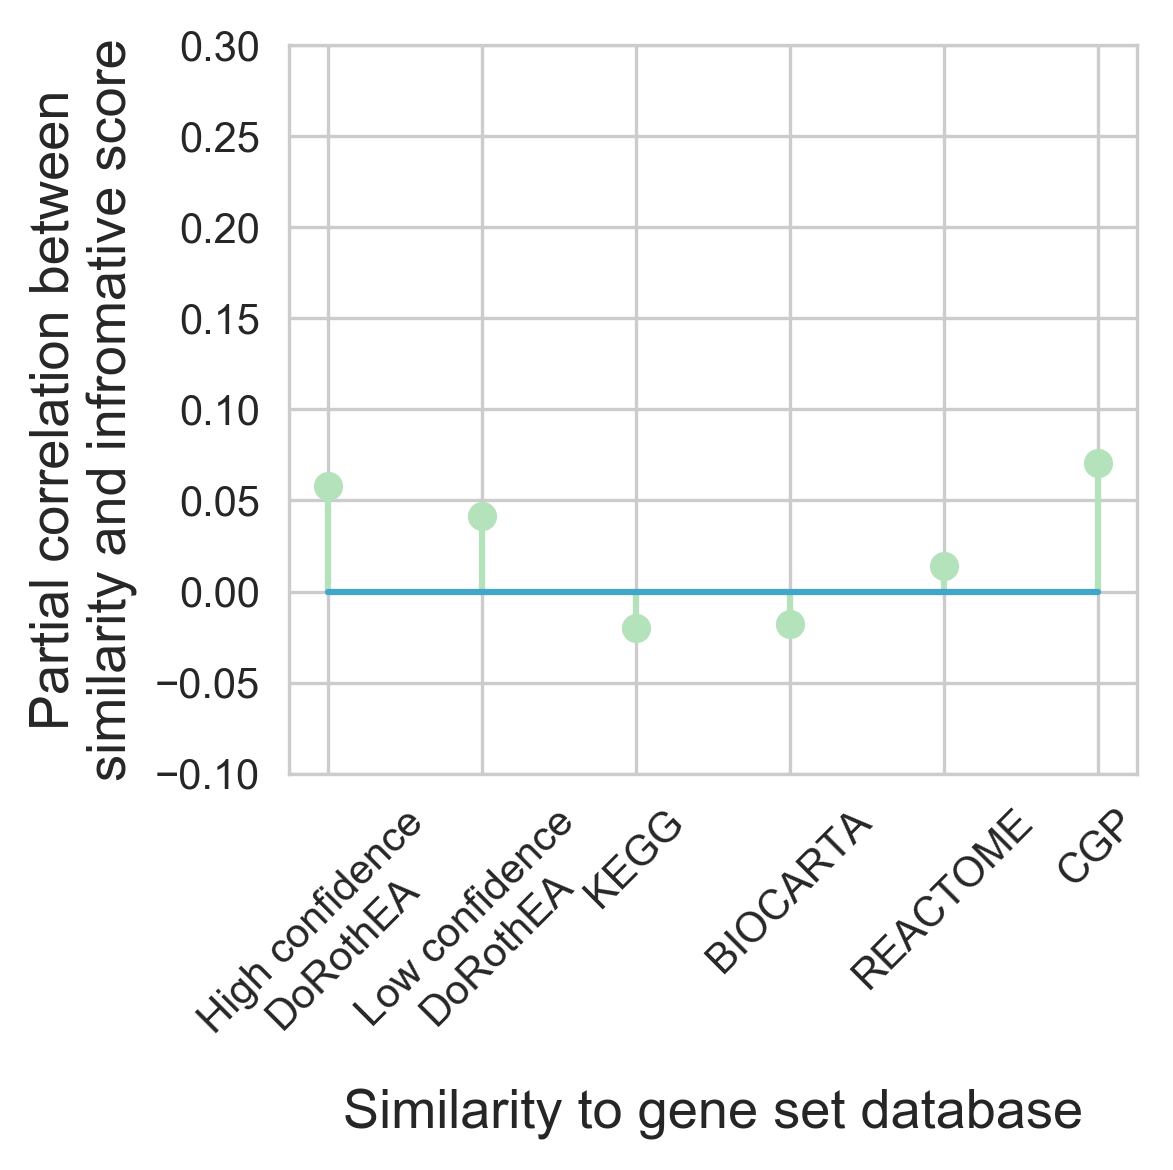

In [127]:
results2 = get_correlations_all_datasets(sim_type='jaccard', rnd_fil='_random_dist_0', bname='progeny', visualise=True)
plt.savefig('../figures/raw/Fig4D.pdf')

REACTOME            1.064747e-01
BEST_dorothea_CD    3.562320e-06
CGP                 1.651477e-29
BIOCARTA            2.088861e-01
KEGG                5.782896e-08
BEST_dorothea_AB    2.231346e-64
dtype: float64
REACTOME            0.038710
BEST_dorothea_CD    0.070971
CGP                 0.236948
BIOCARTA            0.030151
KEGG                0.080955
BEST_dorothea_AB    0.235843
dtype: float64


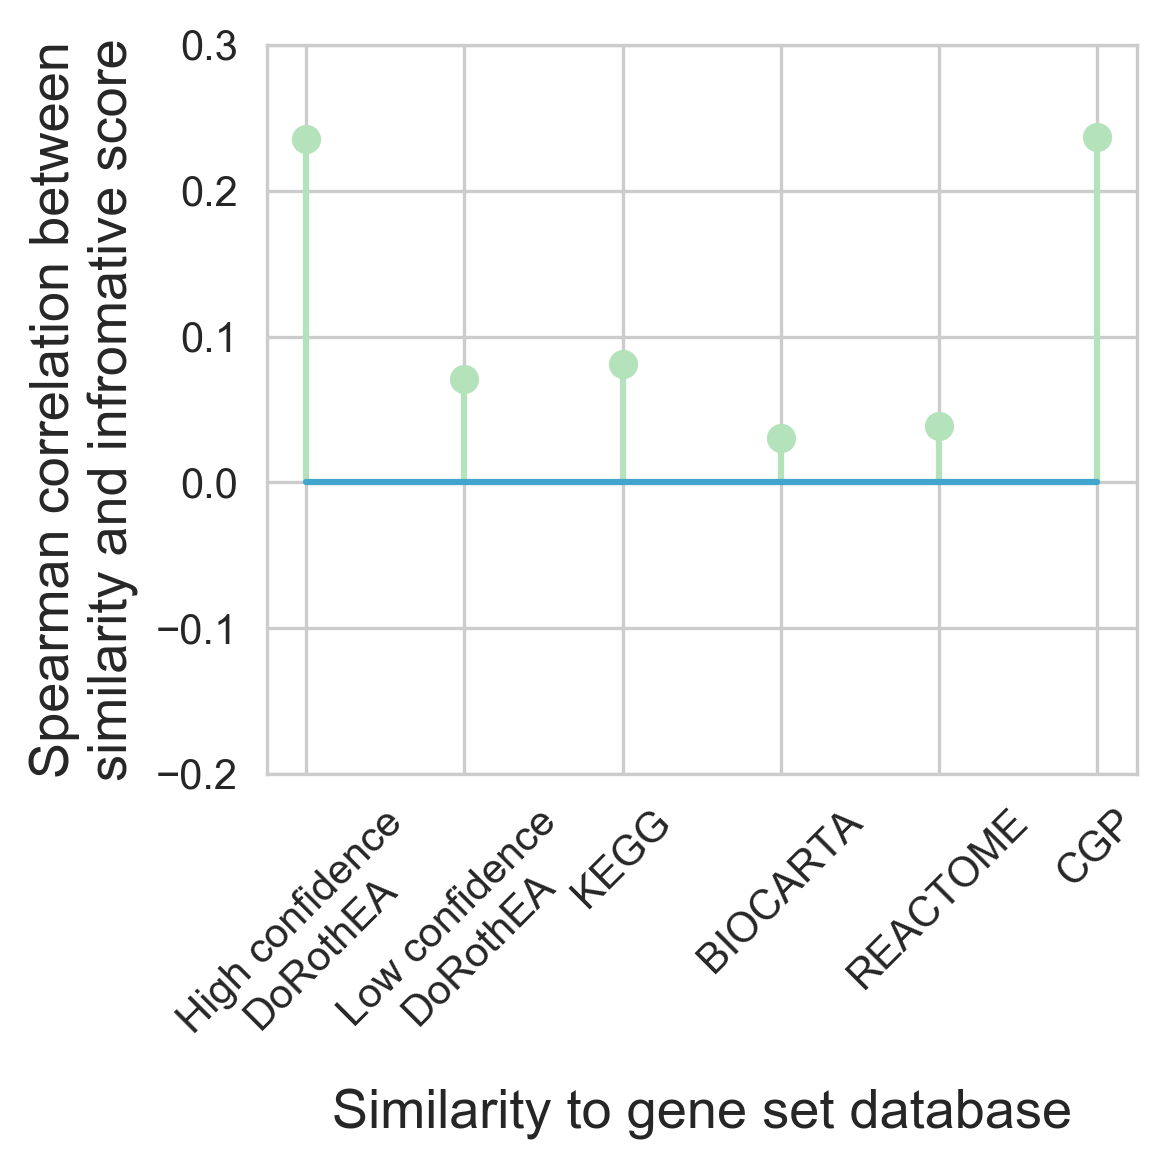

In [9]:
temp = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5A.pdf')

CGP                 3.481051e-24
BIOCARTA            5.844704e-02
REACTOME            3.381912e-03
BEST_dorothea_CD    9.476982e-03
BEST_dorothea_AB    3.598998e-30
KEGG                5.788599e-07
dtype: float64
CGP                 0.214361
BIOCARTA            0.036924
REACTOME            0.056281
BEST_dorothea_CD    0.044944
BEST_dorothea_AB    0.161277
KEGG                0.075275
dtype: float64


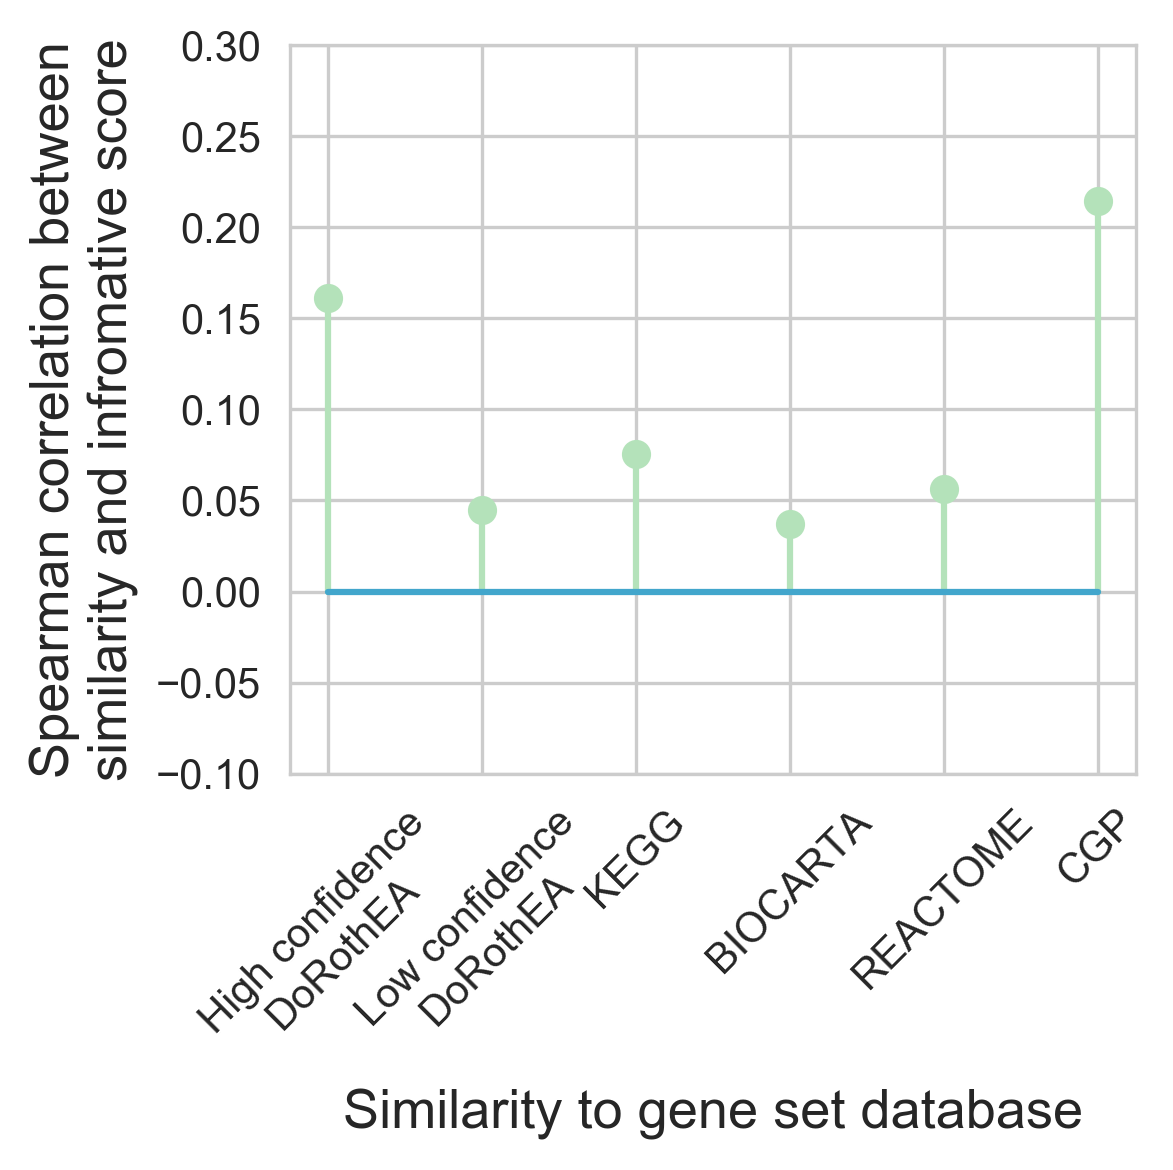

In [17]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5B.pdf')
print(ps)
print(rs)

CGP                 3.107928e-37
BIOCARTA            2.018022e-43
REACTOME            1.073437e-28
BEST_dorothea_CD    4.201915e-29
BEST_dorothea_AB    4.856090e-85
KEGG                1.000000e+00
dtype: float64
CGP                 0.266020
BIOCARTA            0.197307
REACTOME            0.182570
BEST_dorothea_CD    0.160548
BEST_dorothea_AB    0.270377
KEGG                0.001646
dtype: float64


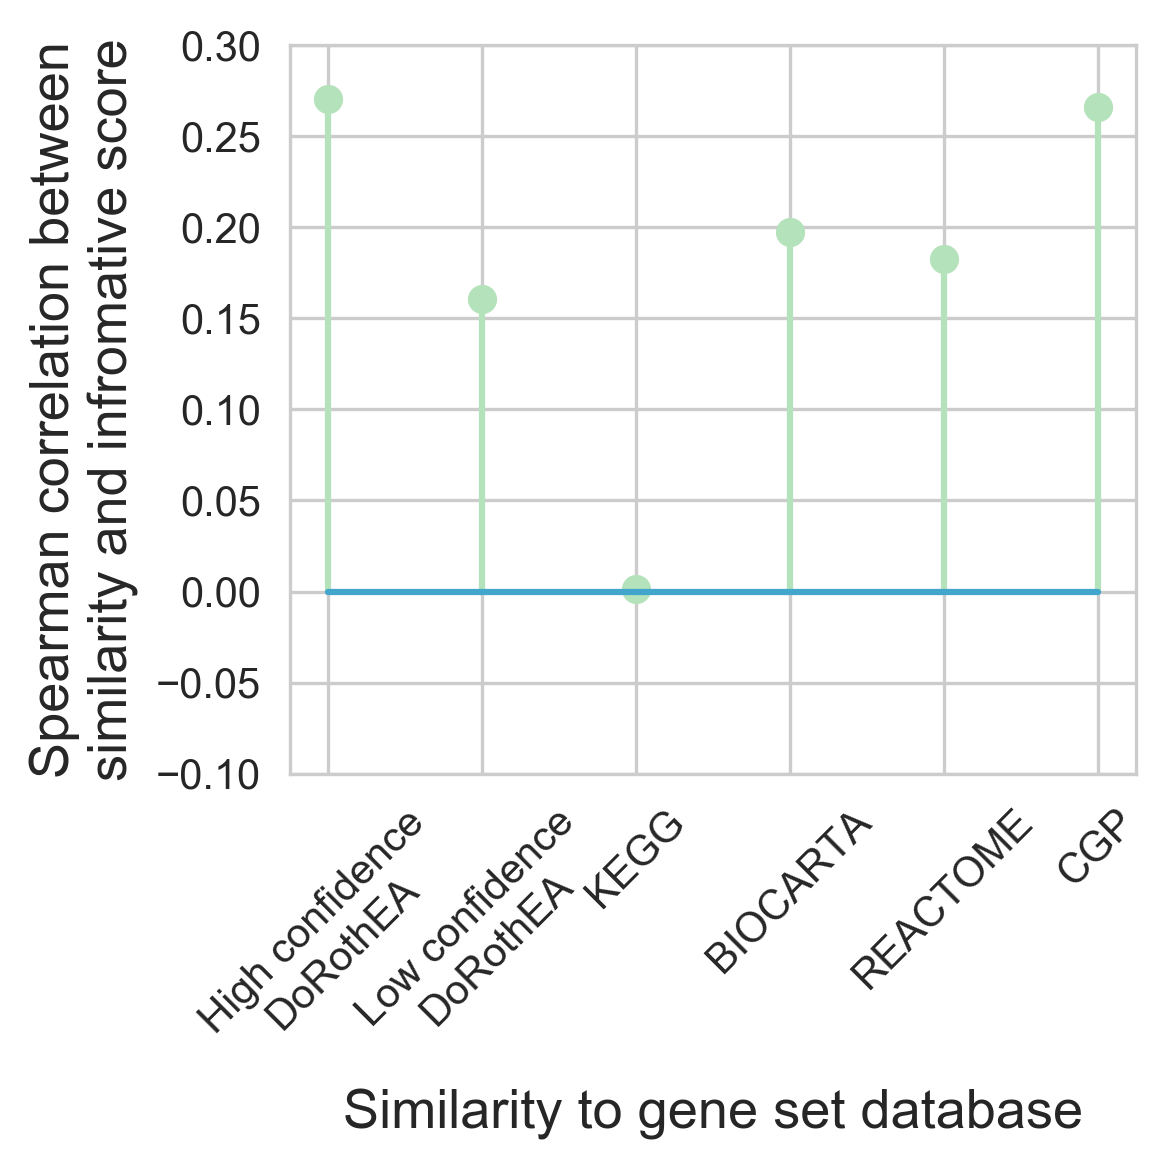

In [18]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='overlap')
plt.savefig('../figures/raw/SFig5C.pdf')
print(ps)
print(rs)

CGP                 9.202136e-33
BIOCARTA            1.891153e-25
REACTOME            4.900745e-17
BEST_dorothea_CD    1.020986e-16
BEST_dorothea_AB    9.874410e-51
KEGG                7.800276e-01
dtype: float64
CGP                 0.249657
BIOCARTA            0.150529
REACTOME            0.139731
BEST_dorothea_CD    0.120702
BEST_dorothea_AB    0.209539
KEGG                0.021398
dtype: float64


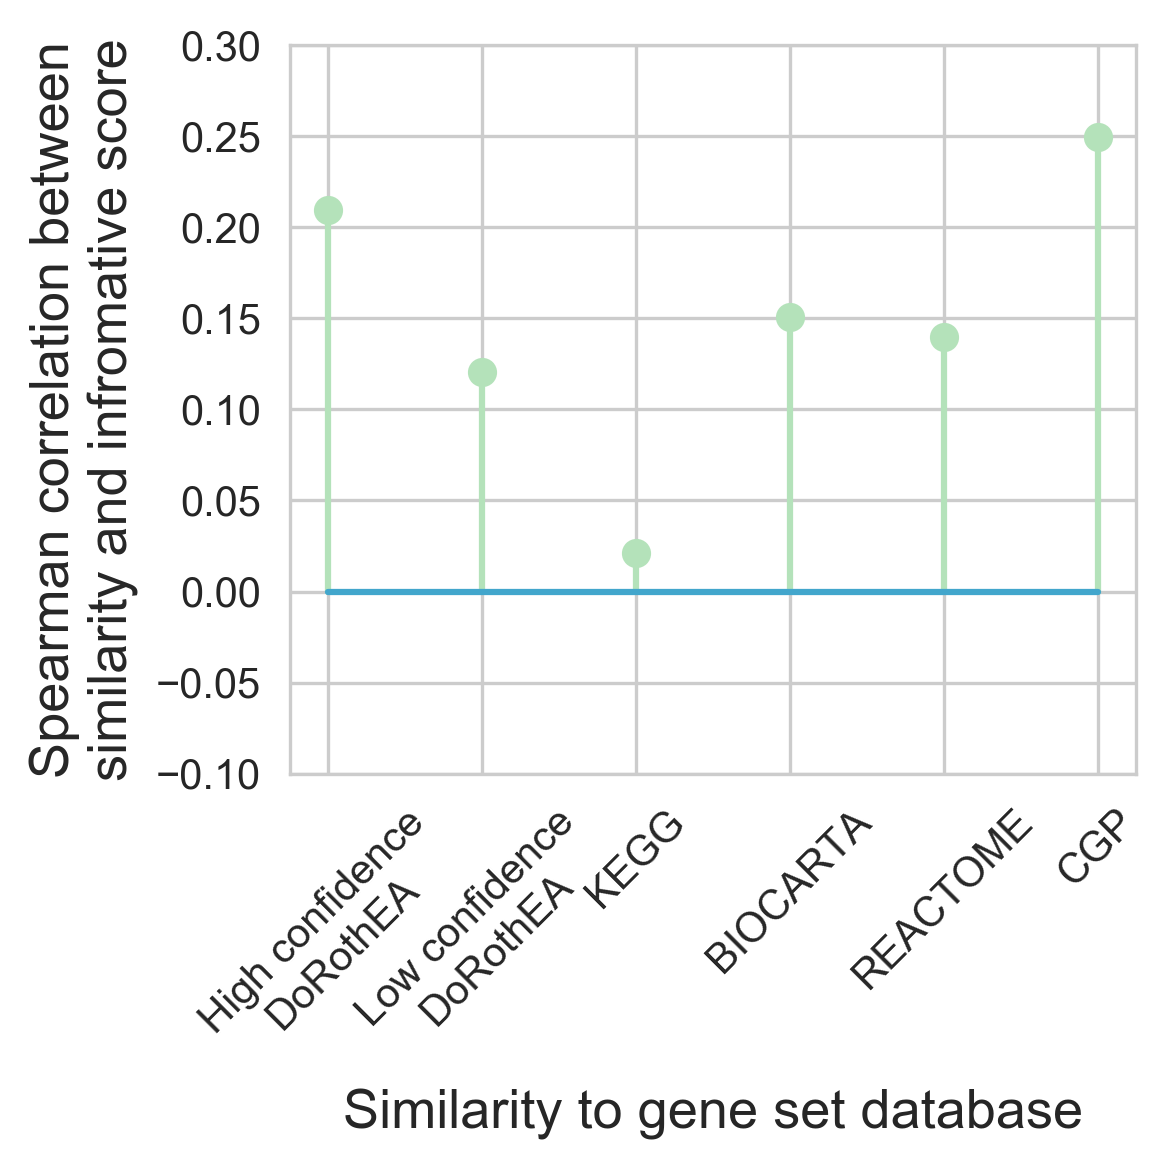

In [19]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='overlap')
plt.savefig('../figures/raw/SFig5D.pdf')
print(ps)
print(rs)

CGP                 1.000000e+00
BIOCARTA            7.705277e-10
REACTOME            1.761115e-01
BEST_dorothea_CD    9.630730e-10
BEST_dorothea_AB    1.927274e-17
KEGG                4.766514e-08
dtype: float64
CGP                -0.027580
BIOCARTA           -0.091562
REACTOME           -0.035555
BEST_dorothea_CD    0.090712
BEST_dorothea_AB    0.121549
KEGG               -0.081318
dtype: float64


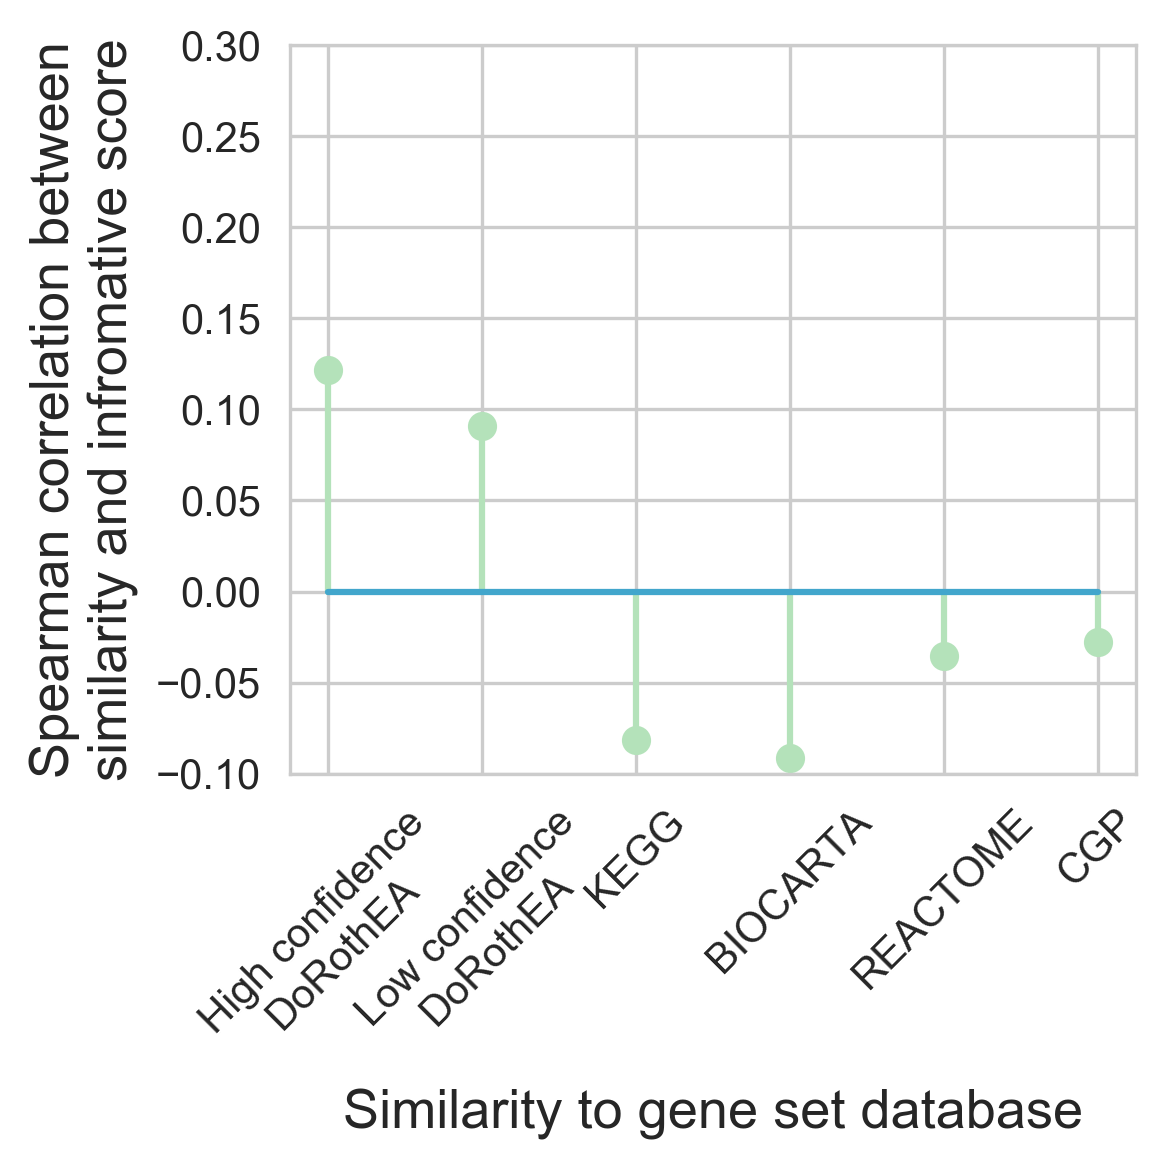

In [20]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5E.pdf')
print(ps)
print(rs)

CGP                 0.000027
BIOCARTA            0.003142
REACTOME            0.016417
BEST_dorothea_CD    1.000000
BEST_dorothea_AB    0.002369
KEGG                0.400170
dtype: float64
CGP                -0.096089
BIOCARTA           -0.049470
REACTOME           -0.048878
BEST_dorothea_CD   -0.004343
BEST_dorothea_AB    0.049640
KEGG               -0.025883
dtype: float64


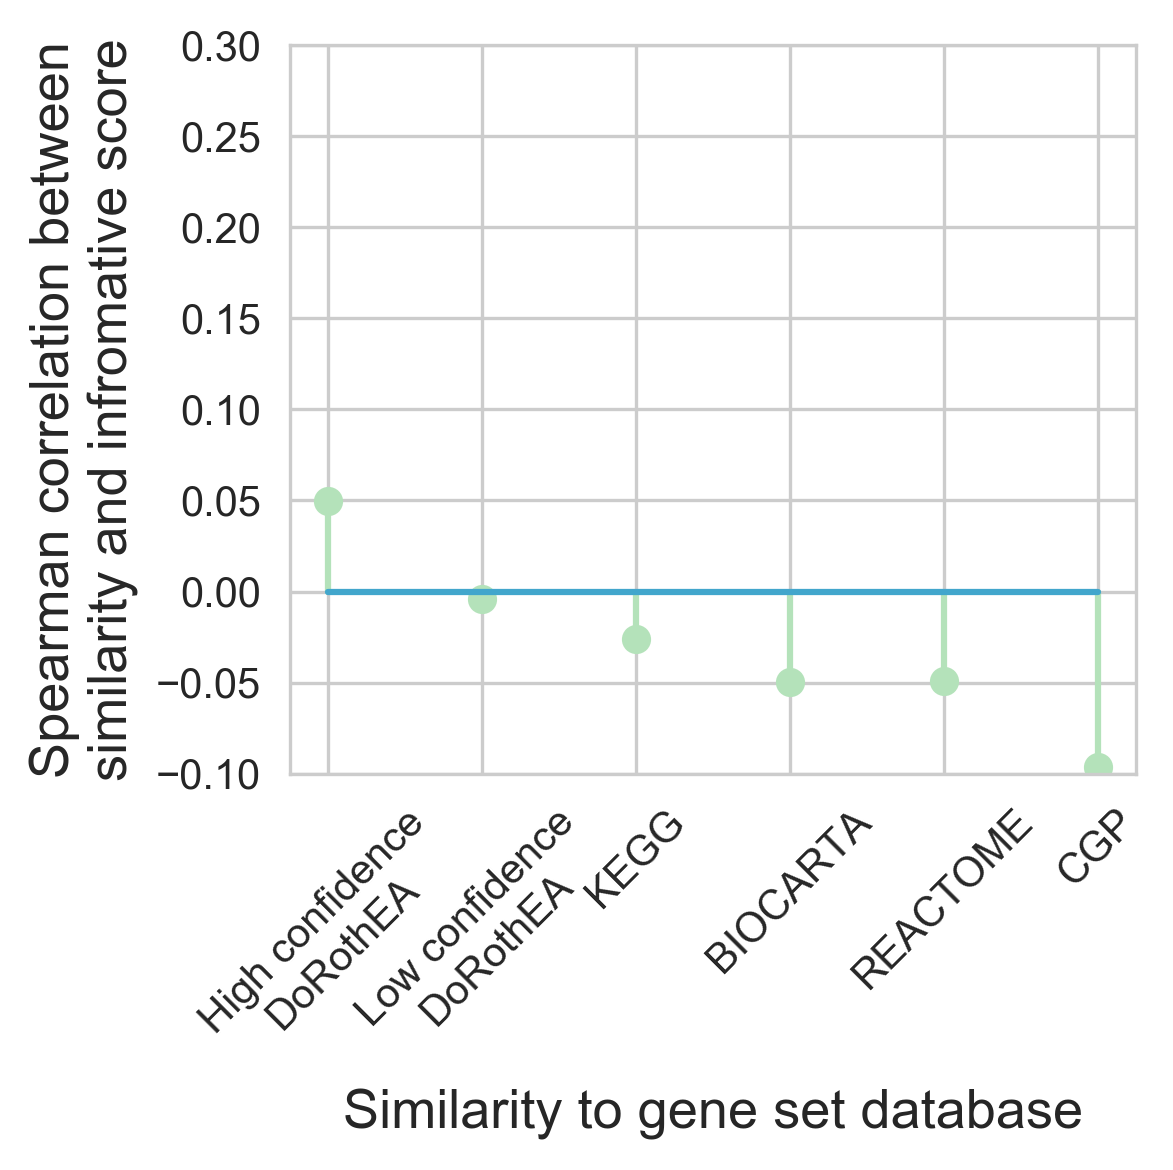

In [21]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5F.pdf')
print(ps)
print(rs)

CGP                 1.000000e+00
BIOCARTA            1.000000e+00
REACTOME            2.448166e-02
BEST_dorothea_CD    3.807639e-20
BEST_dorothea_AB    1.131250e-16
KEGG                1.323772e-13
dtype: float64
CGP                 0.006736
BIOCARTA           -0.004625
REACTOME            0.046856
BEST_dorothea_CD    0.132795
BEST_dorothea_AB    0.118734
KEGG               -0.107516
dtype: float64


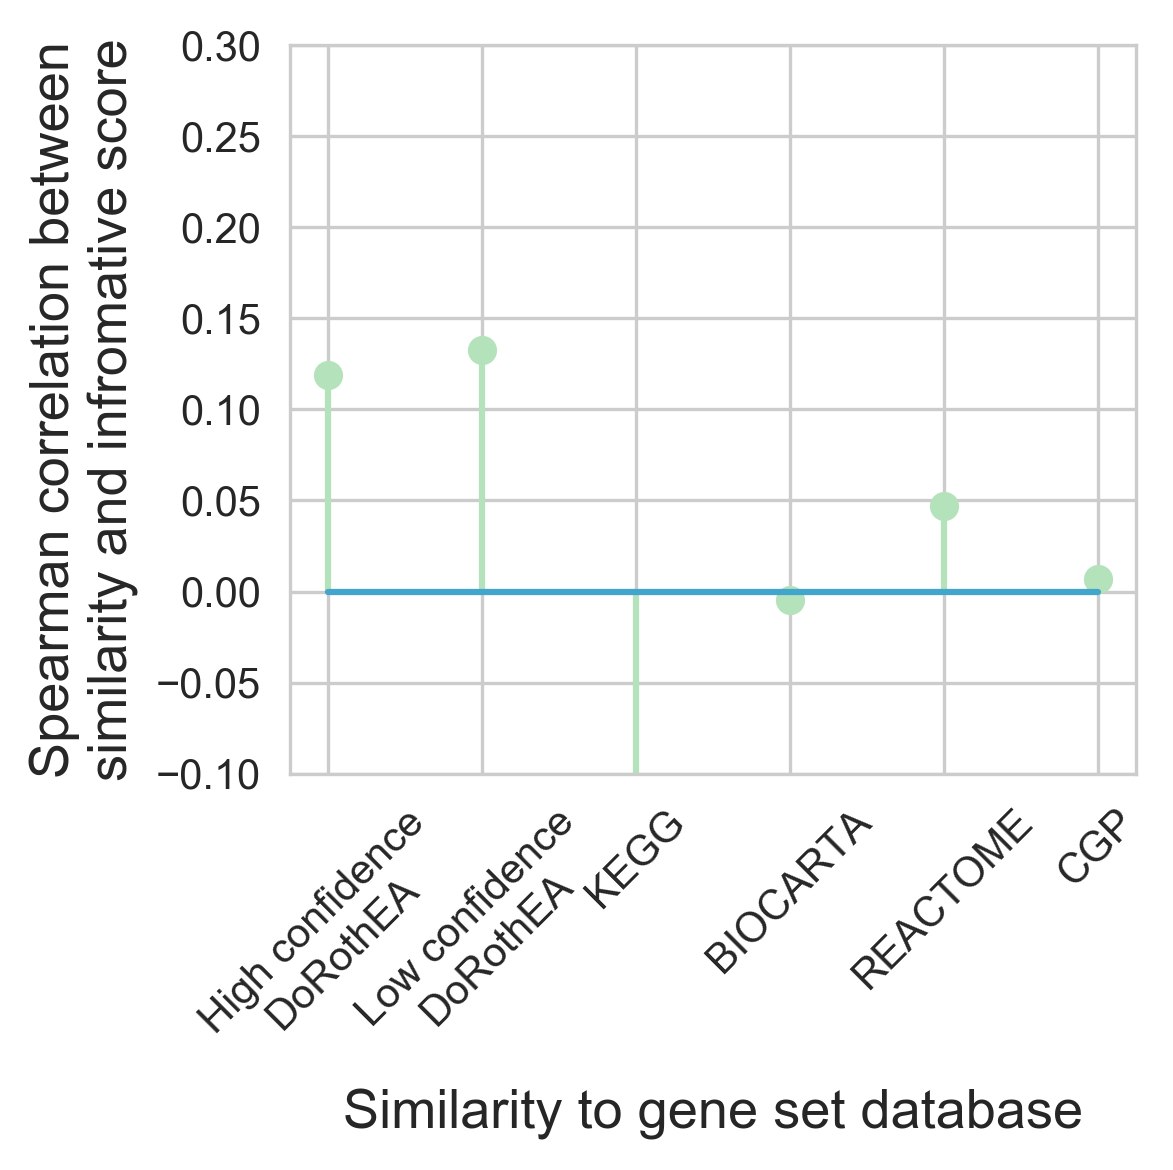

In [22]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='overlap')
plt.savefig('../figures/raw/SFig5G.pdf')
print(ps)
print(rs)

CGP                 8.328213e-01
BIOCARTA            4.231477e-02
REACTOME            1.000000e+00
BEST_dorothea_CD    6.533512e-03
BEST_dorothea_AB    4.891847e-07
KEGG                1.473053e-04
dtype: float64
CGP                -0.031051
BIOCARTA            0.038439
REACTOME            0.019709
BEST_dorothea_CD    0.046405
BEST_dorothea_AB    0.075078
KEGG               -0.059507
dtype: float64


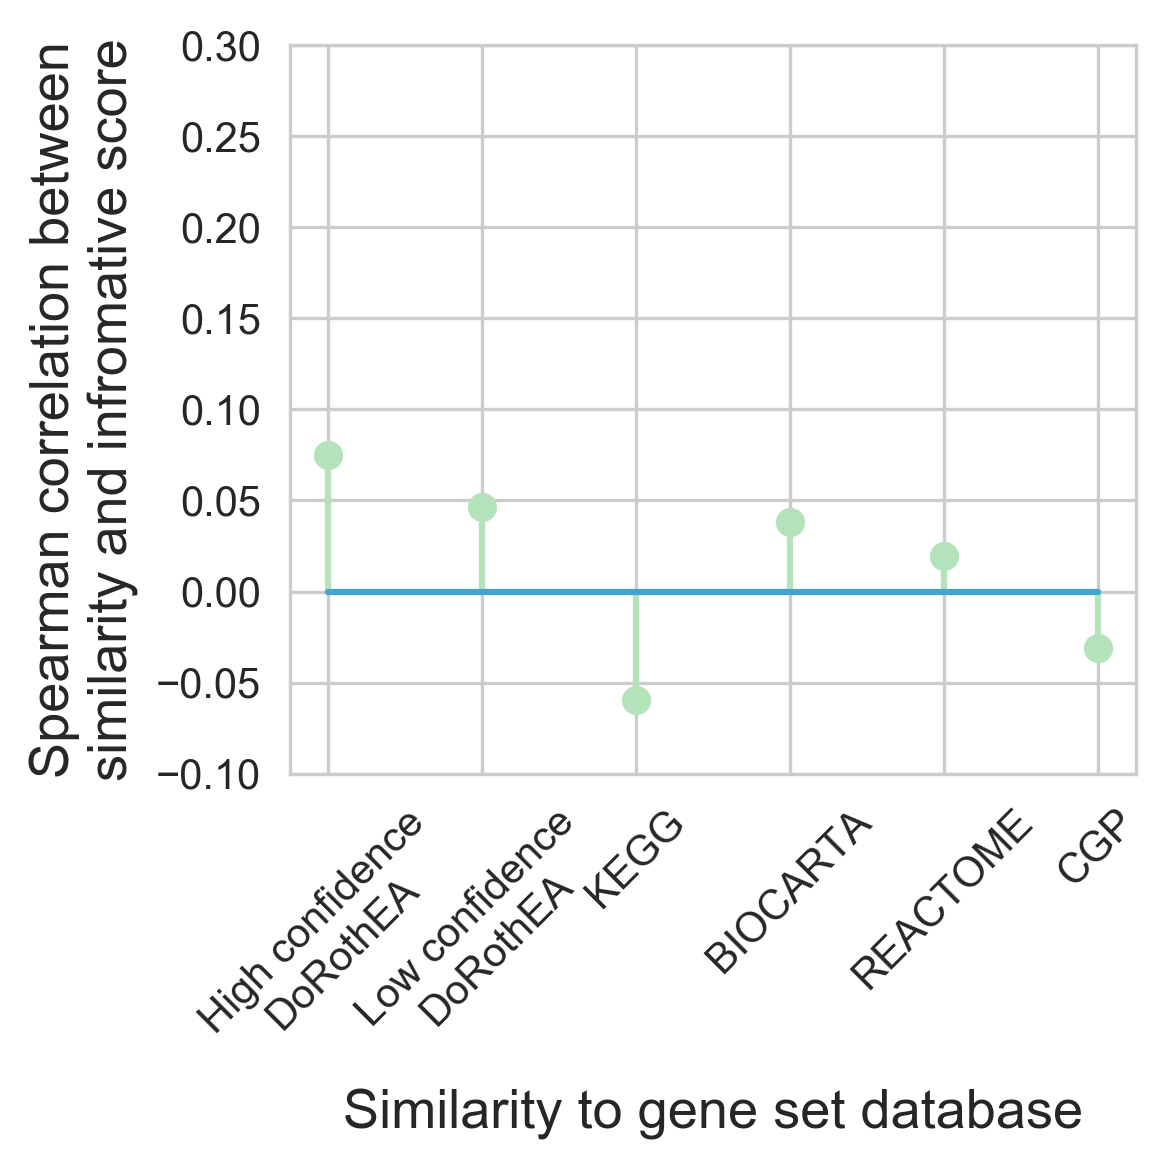

In [23]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='overlap')
plt.savefig('../figures/raw/SFig5H.pdf')
print(ps)
print(rs)

In [135]:
get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='overlap')

,Database,r_spearman,p_spearman,r_part,p_part,Random,Benchmark,Abs
Database,,,,,,,,
BEST_dorothea_AB,High confidence\nDoRothEA,0.209539,1.645735e-51,0.204611,3.783177e-49,_filtered,progeny,
BEST_dorothea_CD,Low confidence\nDoRothEA,0.120702,1.701644e-17,0.080921,1.230467e-08,_filtered,progeny,
KEGG,KEGG,0.021398,1.300046e-01,0.060666,1.738879e-05,_filtered,progeny,
BIOCARTA,BIOCARTA,0.150529,3.151921e-26,0.091965,1.121844e-10,_filtered,progeny,
REACTOME,REACTOME,0.139731,8.167908e-18,0.095671,4.333252e-09,_filtered,progeny,
CGP,CGP,0.249657,1.533689e-33,0.238665,1.025981e-30,_filtered,progeny,


/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


SpearmanrResult(correlation=0.0809553975755057, pvalue=9.638160227397016e-09)


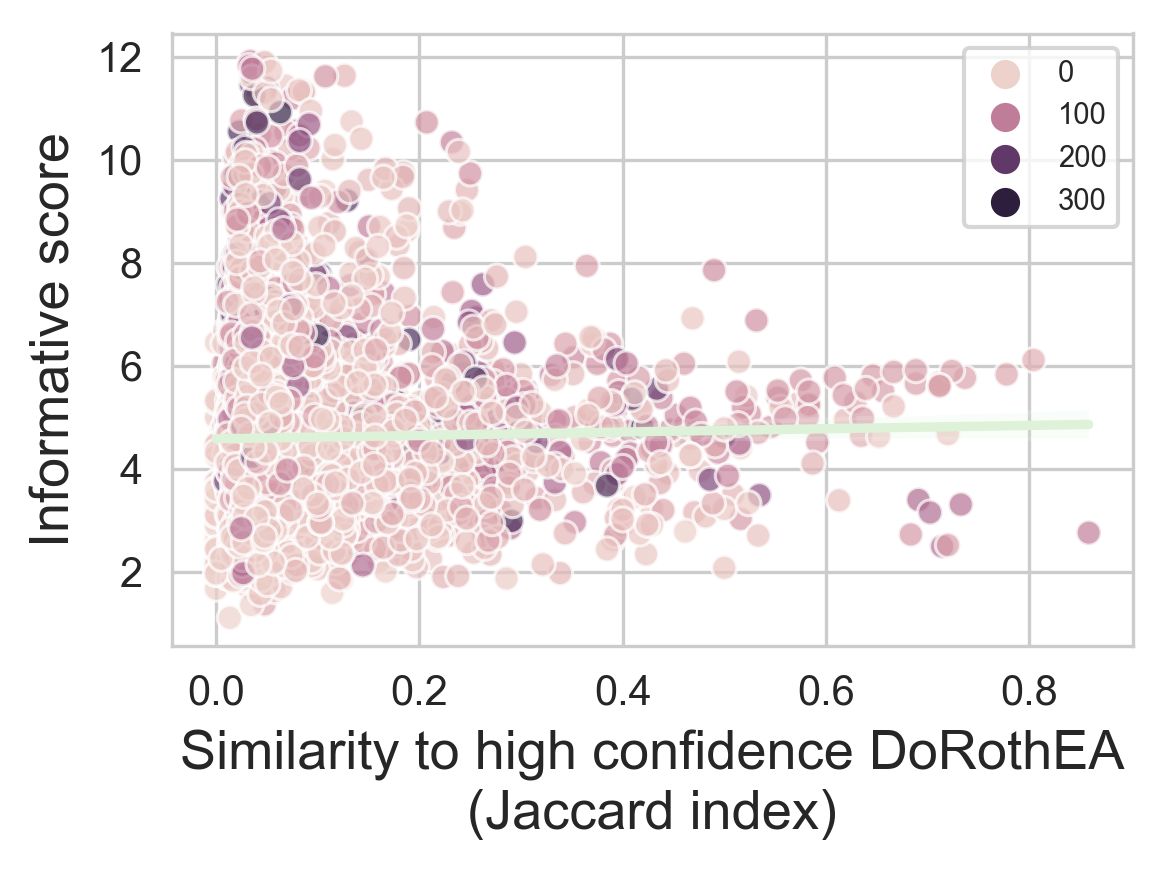

In [106]:
plot_correaltions_all('KEGG','high confidence DoRothEA','_abs','_filtered','progeny','jaccard')

In [122]:
temp = pd.read_csv('../results/genesets/single/csvs/CGP_random_dist_0.csv', sep=',', header=0,
                  index_col=0)

In [123]:
temp['Gene'].value_counts()

CDKN1A       145
TOP2A        122
CDK1         121
FOS          118
MYC          117
CXCL8        113
JUN          111
CCND1        109
RGS2         106
SERPINE1     106
GADD45A      104
ID2          103
EGR1          97
FN1           97
RRM2          97
CD44          96
ATF3          94
IER3          93
AURKA         92
NDRG1         92
CCNA2         91
IGFBP3        91
SOX4          90
THBS1         89
CCNB2         89
CXCR4         89
ISG15         88
CCNB1         88
CLU           87
NAP1L1        86
            ... 
RNA5SP440      1
EMILIN3        1
MYPN           1
GLIDR          1
ZFYVE27        1
MRPS23         1
LRRC7          1
PADI1          1
KIAA1143       1
GOLGA6L4       1
PRB4           1
SLC25A42       1
ACTBL2         1
ZNF614         1
SENP7          1
EVA1C          1
ZNF689         1
ABHD17B        1
SLC6A7         1
ARL17A         1
FSBP           1
GPR135         1
C5orf63        1
PRKACG         1
WDR31          1
SPATA16        1
TERB1          1
KRTAP13-3     